In [1]:
import json
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored

from data_loading import load_tlc_samples
from models import Match, SampleCollection
from config import TLCPaths

In [2]:
def show_search_score_proportion(matches):
    nums_matched = []
    x = np.linspace(0, 1, 10)
    for threshold in x:
        num_matched = len([match for match in matches if match['score'] > threshold])
        nums_matched.append(num_matched / len(matches))

    fig, ax = plt.subplots()
    ax.plot(x, nums_matched)
    ax.set_xlabel("score threshold")
    ax.set_ylabel("% matched")
    ax.grid()
    plt.show()


In [3]:
for file in TLCPaths.project_data_path.iterdir():
    if "matched_solr" in str(file.name):
        print(file.name)

matched_solr_20230403-100734.json
matched_solr_TIME.json
matched_solr_20230403-095600.json
matched_solr_20230403-095605.json
not_matched_solr_20230403-100735.json
not_matched_solr_TIME.json
not_matched_solr_20230403-095608.json


In [4]:
matched_file_path = TLCPaths.project_data_path.joinpath("matched_solr_20230403-100734.json")
not_matched_file_path = TLCPaths.project_data_path.joinpath("not_matched_solr_20230403-100735.json")
# load the two json files 
with open(matched_file_path, "r") as f:
    matched = [x for x in json.load(f)]
with open(not_matched_file_path, "r") as f:
    not_matched = [x for x in json.load(f)]

In [5]:
print(f"{len(matched)=}")
print(f"{len(not_matched)=}")


len(matched)=998
len(not_matched)=0


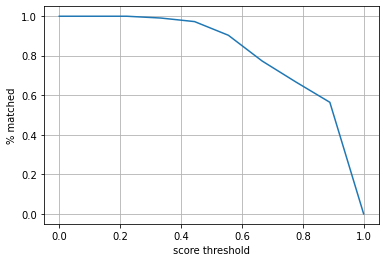

In [6]:
show_search_score_proportion(matched)

In [7]:
matched[0]

{'cui': ['C0034186'],
 'source': ['MDRGER'],
 'language': ['GER'],
 'name': ['Pyelonephritis'],
 'index_term': ['pyelonephriti'],
 'id': 'c8b1ada1-826d-46fa-a6fb-186add6196a1',
 '_version_': 1760194257981800490,
 'score': 1.0,
 'stem': 'pyelonephriti'}

In [8]:
def print_n_matches(matches, n=10):
    for matched_item in random.sample(matches, n):
        print(matched_item['stem'], " matched with ", matched_item['index_term'],
              f"(score = {matched_item['score']})")
        print()


print_n_matches(matched)

reflux  matched with  ['vesikoureteral reflux'] (score = 1.0)

algurie  matched with  ['algerie'] (score = 0.85714287)

nodu  matched with  ['nodu sinuatriali'] (score = 1.0)

ohne pathologischen befu  matched with  ['pathologisch trunkenheit'] (score = 0.5)

interni  matched with  ['otiti interna'] (score = 0.85714287)

atiologie  matched with  ['demenz infolg mulptipl aetiologie'] (score = 0.9)

antidiarrhoikum  matched with  ['antidiarrhoika'] (score = 0.8666667)

regelblutung  matched with  ['regelblutung'] (score = 1.0)

hamatom  matched with  ['hamatom'] (score = 1.0)

endog  matched with  ['serinproteinase-inhibitoren, endog'] (score = 1.0)



In [9]:
threshold = 0.75  # some false negatives with .7, so .69 seems to work good
cutoff_matches = [match for match in matched if match['score'] > threshold]
below_cutoff = [match for match in matched if match['score'] <= threshold]
print(len(cutoff_matches), '/', len(matched))
print("not initially matched: ", len(not_matched))
print_n_matches(cutoff_matches)

672 / 998
not initially matched:  0
zoliakie  matched with  ['zoliakie'] (score = 1.0)

eiweiss  matched with  ['eiweiss'] (score = 1.0)

har  matched with  ['hirnhaut, har'] (score = 1.0)

verzicht  matched with  ['verdicht'] (score = 0.875)

nephroskopie  matched with  ['nephroskopie'] (score = 1.0)

riss  matched with  ['riss'] (score = 1.0)

transpiratio  matched with  ['wavelet-transformatio'] (score = 0.7692308)

zystoskopie  matched with  ['zystoskopie'] (score = 1.0)

osophagiti  matched with  ['osophagiti'] (score = 1.0)

ovar  matched with  ['ovar'] (score = 1.0)



In [10]:
print_n_matches(below_cutoff)

akute appendiziti  matched with  ['appendiziti'] (score = 0.64705884)

weisse blutkorperch  matched with  ['blutkorperch'] (score = 0.6315789)

glutensensitive enteropathie  matched with  ['glutenenteropathie'] (score = 0.64285713)

totale kolektomie  matched with  ['trabekulektomie'] (score = 0.7058823)

cholelith  matched with  ['cholelithiasi'] (score = 0.6923077)

btm  matched with  ['atm'] (score = 0.6666666)

herzschwach  matched with  ['sehschwach'] (score = 0.72727275)

haufiges wasserlassen   matched with  ['wasserlass'] (score = 0.45454544)

anulus umbilicali  matched with  ['aluminiumsilicat'] (score = 0.5294118)

breitbandantibiotikum  matched with  ['antibiotikum-bedingt koliti'] (score = 0.57142854)



In [11]:
# print_n_matches(not_matched)

In [12]:
# combine not matched by score and not matched by solr
below_cutoff = not_matched + below_cutoff

In [13]:
print(
    f"Unique matched terms = {len(cutoff_matches)}")
print(
    f"Unique non-matched terms = {len(below_cutoff)}")


Unique matched terms = 672
Unique non-matched terms = 326


In [14]:
samples_to_annotate_path = TLCPaths.project_data_path.joinpath("samples_to_annotate.json")
samples_to_validate_path = TLCPaths.project_data_path.joinpath("samples_to_validate.json")
with open(samples_to_annotate_path, "w") as fp:
    json.dump([sample for sample in below_cutoff], fp)
    
with open(samples_to_validate_path, "w") as fp:
    json.dump([sample for sample in cutoff_matches], fp)

## Analyze not mached mentions

In [15]:
sample_collection = SampleCollection(load_tlc_samples())
annotations = [ann for sample in load_tlc_samples() for ann in sample.annotations]

with open('search_terms_single_and_ids.json', 'r') as fp:
    terms_and_ids = json.load(fp)
    
import os
os.environ["FORCE_COLOR"] = "1"

In [25]:
for search_term in below_cutoff[:10]:
    unique_ids = terms_and_ids[search_term['stem']]
    annotation = next(ann for ann in annotations if ann.id in unique_ids)
    sample = sample_collection.get_sample_by_annotation_id(annotation.id)
    text = sample.text
    colored_mention = colored(text[annotation.span_start:annotation.span_end], "red")
    text_with_colors = text[:annotation.span_start] + colored_mention + text[annotation.span_end:]
    print(text_with_colors)

Thread: [Unerklärliche Bauchschmerzen]
Text: [Hallo!
Auch ich dachte laut der Beschwerden von einigen von euch gleich an Gallensteine.
Beim Ultraschall muss man komplett nüchtern sein, d.h. nicht mal Wasser trinken vorher, sonst kann man bei der Gallenblase nichts erkennen. Es gibt auch Gallensteine in den Gallengängen, wobei leider eine Ultraschalluntersuchungen meistens nicht reicht um diese zu erkennen. Da kann man eine ERCP (Sp\u00edegelung) machen.
Obwohl ich aber glaube, dass sie eure Ärzte die einen Oberbauchultraschall bei euch gemacht haben, sich die Gallenblasen sicher genau angesehen haben, da die Beschwerden ja auch dafür in Frage kommen.]

Thread: [Magen Darm Grippe in Dauerschleife]
Text: [Wie kann es dann aber sein, dass nur sie sich immer wieder neu ansteckt und wir anderen drei noch nicht?]

Thread: [Appetitlosigkeit]
Text: [Hallo Liebe med1 Mitglieder,
Vorgeschichte in der Kurzfassung:
- Sept 16 - März 17 linke Unterbauchschmerzen bis der Blinddarm im März rauskam (wa